In [1]:
import math
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from typing import Callable

# Notebook Conventions

```
m: number of weights
n: number of examples

Matrix rows: examples
Matrix columns: datapoint
```

In [81]:
def grid_dims(grid_n: int):
    w = True
    grid_w = grid_h = math.floor(math.sqrt(grid_n))
    
    while (grid_w * grid_h) < grid_n:
        if w: grid_w += 1
        else: grid_h += 1
        w = not w
    
    return grid_h, grid_w

def plot_images(x: np.array, y: np.array, y_hat: np.array=None, img_w: int=None, img_h: int=None, grid_n: int=9):
    '''
    Plots a grid of images
    '''
    
    n, m = x.shape
    if grid_n > n: raise ValueError
    if not img_w or not img_h: img_w = img_h = math.floor(math.sqrt(m))
    
    grid_h, grid_w = grid_dims(grid_n)
    
    fig, axs = plt.subplots(grid_h, grid_w)
    fig.patch.set_facecolor((0.9, 0.9, 0.9))
    axs = axs.reshape(grid_h, grid_w)
    
    sample_imgs = random.sample(range(n), grid_n)
    
    for i in range(grid_w):
        for j in range(grid_h):
            axs[j, i].axis('off')
    
    for i, j in enumerate(random.sample(range(n), grid_n)):
        ax = axs[i//grid_w, i%grid_w]
        img = x[j].reshape(img_w, img_h)
        
        ax.imshow(img, cmap='Greys',  interpolation='nearest')
        ax.set_title(f'{y[j]}, {y_hat[j] if y_hat is not None else ""}')
    
    plt.tight_layout()

In [77]:
data = np.load('../mnist.npz')

In [119]:
x_train_raw = data['x_train']
y_train = data['y_train']
x_test_raw = data['x_test']
y_test = data['y_test']

all_train_n, img_w, img_h = x_train_raw.shape
all_test_n, img_w, img_h = x_test_raw.shape

print(f'MNIST')
print()
print(f'x_train_raw:\t{x_train_raw.shape}')
print(f'y_train:\t{y_train.shape}')
print(f'x_test_raw:\t{x_test_raw.shape}')
print(f'y_test:\t\t{y_test.shape}')
print()
print(f'all_train_n:\t{all_train_n}')
print(f'all_test_n:\t{all_test_n}')
print(f'img:\t\t{img_w}x{img_h}')

MNIST

x_train_raw:	(60000, 28, 28)
y_train:	(60000,)
x_test_raw:	(10000, 28, 28)
y_test:		(10000,)

all_train_n:	60000
all_test_n:	10000
img:		28x28


# Binary Classification

In [123]:
# Clean train data

x_train = x_train_raw/255
x_train = x_train.reshape(all_train_n, img_w * img_h)

y_train = y_train.reshape(all_train_n, 1)

zeros_ones_train = np.isin(y_train, (0, 1))
print(x_train.shape)
x_train = x_train[zeros_ones_train]
y_train = y_train[zeros_ones_train]

# Clean test data

x_test = x_test_raw/255
x_test = x_test.reshape(all_test_n, img_w * img_h)

y_test = y_test.reshape(all_test_n, 1)

zeros_ones_test = np.isin(y_test, (0, 1))

x_test = x_test[zeros_ones_test]
y_test = y_test[zeros_ones_test]

# Print data summary

train_n, m = x_train.shape
test_n, m = x_test.shape

print(f'MNIST (0, 1)')
print()
print(f'x_train:\t{x_train.shape}')
print(f'y_train:\t{y_train.shape}')
print(f'x_test:\t\t{x_test.shape}')
print(f'y_test:\t\t{y_test.shape}')
print()
print(f'train_n:\t{train_n}')
print(f'test_n:\t\t{test_n}')
print()
print(f'img:\t\t{img_w}x{img_h} = {m}')

plot_images(x=x_train, y=y_train)

(60000, 784)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 784 but corresponding boolean dimension is 1

## Implementation 1

In [86]:
class Sigmoid:
    def activation(x: np.array):
        return np.reciprocal(1 + np.exp(-x))
    
    def interpret(y: np.array):
        return (y > 0.5).astype(int)

In [87]:
class BCE:
    def loss(y_hat: np.array, y: np.array):
        m, *_ = y_hat.shape
        return -(np.dot(y, np.log(y_hat)) + np.dot(1-y, np.log(1-y_hat)))/m
    
    def grad_w(x:np.array, y_hat: np.array, y: np.array, **kwargs):
        m, *_ = y_hat.shape
        return np.matmul(x, y_hat - y)/m
    
    def grad_b(y_hat:np.array, y:np.array, **kwargs):
        m, *_ = y_hat.shape
        return np.sum(y_hat - y)/m

In [111]:
class Dense:
    a = 0.1
    
    def __init__(self, i: int, o: int, activation) -> None:
        if i < 1 or o < 1: raise ValueError
        
        self.m = i
        
        self.w = np.zeros((i, o))
        self.b = np.zeros(o)

        self.activation = activation.activation
        self.interpret = activation.interpret

    def forward(self, x: np.array, interpret: bool=False):
        y = self.activation(np.matmul(x, self.w) + self.b)
        
        print(f'Forward: {x.shape} * {self.w.shape} + {self.b.shape} = {y.shape}')
        
        if interpret: 
            return self.interpret(y)
        
        return y
    
    def backward(self, x: np.array, y: np.array, loss):
        y_hat = self.forward(x)
        
        grad_w = loss.grad_w(x=x, y_hat=y_hat, y=y)
        grad_b = loss.grad_b(y_hat=y_hat, y=y)
        
        self.w -= self.a * grad_w
        self.b -= self.a * grad_b
        
        return loss.loss(y_hat=y_hat, y=y)
    
    def error(self, x: np.array, y: np.array):
        m = y.shape
        
        y_hat = self.forward(x=x, interpret=True)

        return float(abs(np.sum(y - y_hat)/m))
    
    def __str__(self):
        return f'Dense[{self.m}]'

In [112]:
class NN:
    def __init__(self, *args):
        self.layers = args
    
    def forward(self, x: np.array, interpret: bool=False):
        y = x
        for layer in self.layers:
            y = layer.forward(y)
        return y
    
    def __str__(self):
        return '  ->  '.join(['x'] + [str(layer) for layer in self.layers] + ['y'])
    
    def __getitem__(self, key: int):
        return self.layers[key]

## One Layer

#### Train

weights: (784, 1)
Forward: (2115, 784) * (784, 1) + (1,) = (2115, 1)
error: 1135.0
Forward: (2115, 784) * (784, 1) + (1,) = (2115, 1)


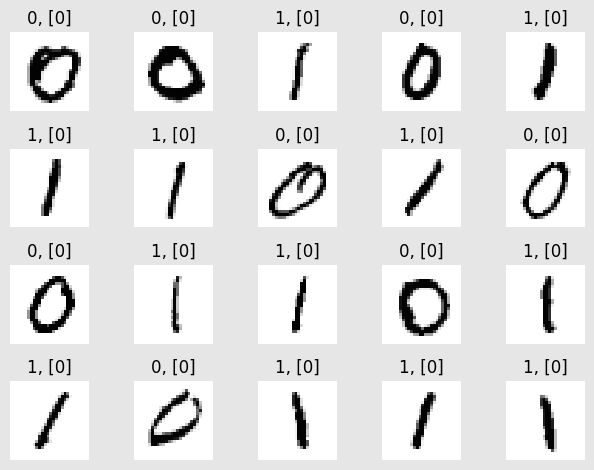

In [113]:
dense = Dense(i=m, o=1, activation=Sigmoid)

print(f'weights: {dense.w.shape}')
print(f'error: {dense.error(x=x_test, y=y_test)}')

y_hat = dense.forward(x_test, interpret=True)
plot_images(x=x_test, y=y_test, y_hat=y_hat, grid_n=20)

In [95]:
epochs = 200

loss = [dense.backward(x=x_train, y=y_train, loss=BCE) for i in range(epochs)]

plt.plot(range(epochs), loss)
plt.title("Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 12665 is different from 784)

Text(0.5, 1.0, 'Weight Grid')

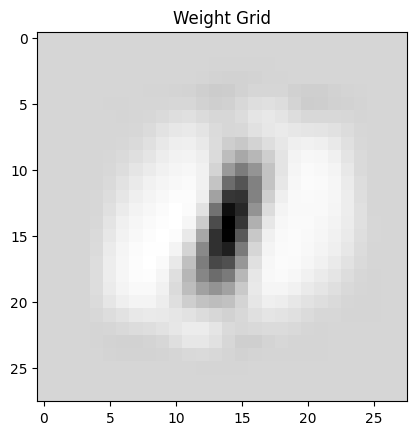

In [11]:
plt.imshow(dense.w.reshape(28, 28), cmap='Greys',  interpolation='nearest')
plt.title("Weight Grid")

#### Testing

error: 0.0009456264775413711


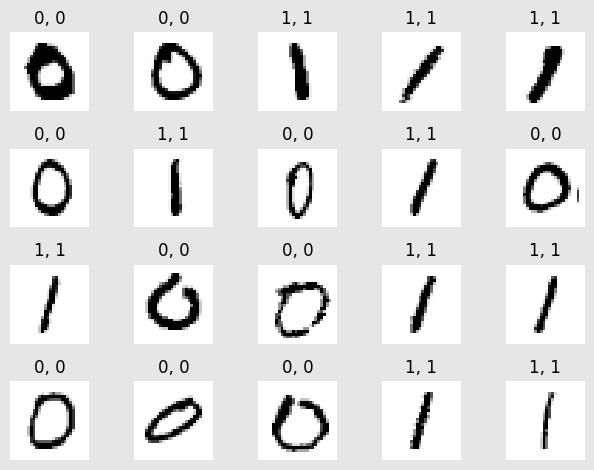

In [15]:
print(f'error: {dense.error(x=x_test, y=y_test)}')

y_hat = dense.forward(x=x_test, interpret=True)
plot_images(x=x_test, y=y_test, y_hat=y_hat, grid_n=20)

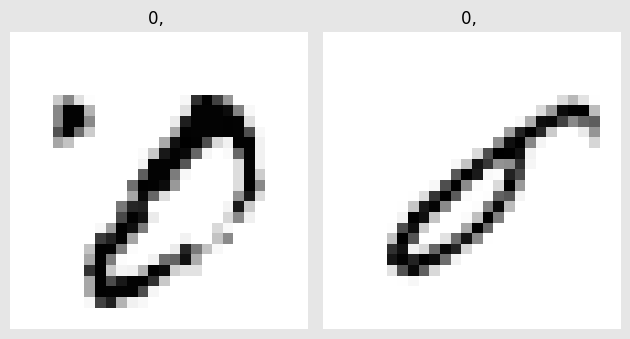

In [13]:
wrong_i = [i for i in range(test_n) if y_test[i] != y_hat[i]]

wrong_x = x_test[:, wrong_i]
wrong_y = y_test[wrong_i]

wrong_n,  = wrong_y.shape

plot_images(x=wrong_x, y=wrong_y, grid_n = wrong_n)

## Two Layer

#### Train

In [62]:
m_1, m_2 = m, 10

nn = NN(
    Dense(i=m_1, o=m_2, activation=Sigmoid), 
    Dense(i=m_2, o=1, activation=Sigmoid)
)

print(nn)

nn[0].w.shape


x  ->  Dense[784]  ->  Dense[10]  ->  y


(10, 784)

In [55]:
nn.forward(x_train)

ValueError: operands could not be broadcast together with shapes (10,12665) (10,) 